In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from entsoe import EntsoeRawClient
from entsoe import EntsoePandasClient


from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense,LSTM,Input,Flatten
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from numpy import array

sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-notebook')

# Time-series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Modelling and Forecasting
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector

# Keras
from keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN, Dropout, GRU, Bidirectional
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import concatenate

import pickle 

#pd.set_option('display.max_rows', None)

## Read countries

In [2]:
def read_countries(df):

    df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
    df = df.set_index('Unnamed: 0')
    df.index.freq ='60min'
    df = df[['True value','Provider 1','Provider 2','Provider 3','hour','dayofweek','month','is_weekend','quarter']]

    return df

In [3]:
greece = read_countries(pd.read_csv('greece.csv'))
bulgaria = read_countries(pd.read_csv('bulgaria.csv'))
romania = read_countries(pd.read_csv('romania.csv'))
italy = read_countries(pd.read_csv('italy.csv'))

## Adding cyclical features

In [4]:
def cyclical_features(df):

    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24.0)
    
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7.0)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7.0)

    df.drop(['hour','dayofweek','month','is_weekend','quarter'],axis=1,inplace=True)

    return df


cyclical_greece = cyclical_features(greece)

## Creating Functions

### Creating Data for LSTM

In [5]:
def createXY(dataset, n_lags):

    dataX, dataY = [], []

    
    for i in range(n_lags, len(dataset)):
            dataX.append(dataset[i - n_lags:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
        

    return np.array(dataX),np.array(dataY)

### Plot to see training loss vs validation loss

In [6]:
def plot_model_loss(history, title):

    plt.figure(figsize=(8, 3.5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

### Metrics

In [7]:
def weekly_evaluation(y_test, y_pred, data_test,title,dates):

     
    plt.plot(dates, y_test, color='red', label='Actual')
    plt.plot(dates, y_pred, color='blue', label='Predicted')

    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    
    
    plt.xticks(rotation=0)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('MWatt')
    plt.legend()

    
    plt.show()

    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    mape = np.round(mape,3)
    mae = np.round(mae,3)
    mse = np.round(mse,3)
    
    
    
    
    print('MAPE: %f   --  MAE: %f  --  MSE: %f' % (mape, mae, mse))
      
    return

In [8]:
def daily_evaluation(y_test, y_pred, data_test,title):

  hours = np.arange(0, 24)  

  plt.plot(hours,y_test, label = 'True values',marker='o')
  plt.plot(y_pred, label = 'Predicted values',marker='x',linestyle='--')

  #plt.xticks( np.arange(0, len(data_test), 383),  data_test.index [np.arange(0, len(data_test), 383)], rotation=45)
  

  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Price of MWh')
  plt.legend()
  plt.show()

  mape = mean_absolute_percentage_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)


  mape = np.round(mape,3)
  mae = np.round(mae,3)
  mse = np.round(mse,3)




  print('MAPE: %f   --  MAE: %f  --  MSE: %f' % (mape, mae, mse))
  
  return

# Greece

## Splitting Data

In [9]:
X_train = cyclical_greece.loc[:'2024-07-31 23:00:00']

X_val = cyclical_greece.loc['2024-08-01 00:00:00':'2024-08-15 23:00:00']

X_test = cyclical_greece.loc['2024-08-16 00:00:00':]

In [10]:
X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == len(cyclical_greece)

True

## Scaling

In [11]:
scaler = MinMaxScaler()

data_train_scaled = scaler.fit_transform(X_train.values)

data_val_scaled = scaler.transform(X_val.values)

data_test_scaled = scaler.transform(X_test.values)

## LSTM [48 LAGS]

In [12]:
params = {
    'neurons': 32,
    'batch_size': 32,
    'epochs': 80,
    'lags': 48,
    'loss': 'mean_absolute_error',
    'learning_rate': 1e-2,
    'activation': 'elu',
    'reduce_lr': ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=8, verbose=2, mode='auto', min_delta=0.01, cooldown=0, min_lr=0),
}
optimizer =  Adam(learning_rate=params['learning_rate'])

In [13]:
trainX, trainY = createXY(data_train_scaled, params['lags'])
valX,   valY   = createXY(data_val_scaled, params['lags'])
testX,  testY  = createXY(data_test_scaled, params['lags'])

trainX.shape, trainY.shape

((5064, 48, 8), (5064,))

In [14]:
# Define the model
model_lstm_48 = Sequential()

model_lstm_48.add(LSTM(units=params['neurons'], activation=params['activation'], input_shape=(trainX.shape[1], trainX.shape[2])))

model_lstm_48.add(Dense(1))

model_lstm_48.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

# Train the model
history_lstm_48 = model_lstm_48.fit(trainX, trainY, epochs=params['epochs'], validation_data=(valX, valY), batch_size=params['batch_size'], callbacks=[params['reduce_lr']])

Epoch 1/80
159/159 [==============================] - 6s 25ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0233 - val_mae: 0.0233 - lr: 0.0100
Epoch 2/80
159/159 [==============================] - 3s 22ms/step - loss: 0.0159 - mae: 0.0159 - val_loss: 0.0182 - val_mae: 0.0182 - lr: 0.0100
Epoch 3/80
159/159 [==============================] - 3s 19ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0167 - val_mae: 0.0167 - lr: 0.0100
Epoch 4/80
159/159 [==============================] - 3s 19ms/step - loss: 0.0134 - mae: 0.0134 - val_loss: 0.0165 - val_mae: 0.0165 - lr: 0.0100
Epoch 5/80
159/159 [==============================] - 3s 19ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0170 - val_mae: 0.0170 - lr: 0.0100
Epoch 6/80
159/159 [==============================] - 3s 19ms/step - loss: 0.0131 - mae: 0.0131 - val_loss: 0.0167 - val_mae: 0.0167 - lr: 0.0100
Epoch 7/80
159/159 [==============================] - 3s 19ms/step - loss: 0.0125 - mae: 0.0125 - val_loss: 0.0199 - val_mae

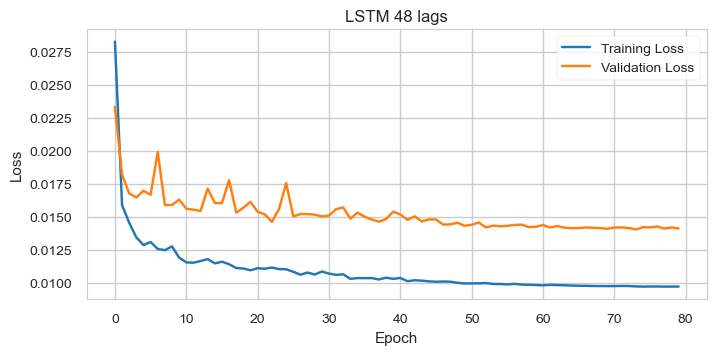

In [15]:
plot_model_loss(history_lstm_48,'LSTM 48 lags')

In [16]:
prediction_lstm_48 = model_lstm_48.predict(testX)

prediction_reverselyscaled_lstm_48 = scaler.inverse_transform(np.repeat(prediction_lstm_48, data_test_scaled.shape[1], axis=-1))[:, 0]

testY = testY.reshape(-1, 1)

testY_extended_lstm_48 = np.hstack([testY, np.zeros((testY.shape[0], data_test_scaled.shape[1] - 1))])

y_test = scaler.inverse_transform(testY_extended_lstm_48)[:, 0]

11/11 [==============================] - 0s 7ms/step


In [17]:
len(X_test)

384

In [18]:
y_test.shape

(336,)

In [19]:
prediction_reverselyscaled_lstm_48.shape

(336,)

In [20]:
y_test[-14*24:-7*24].shape

(168,)

## Evaluate (18 August - 24 August)

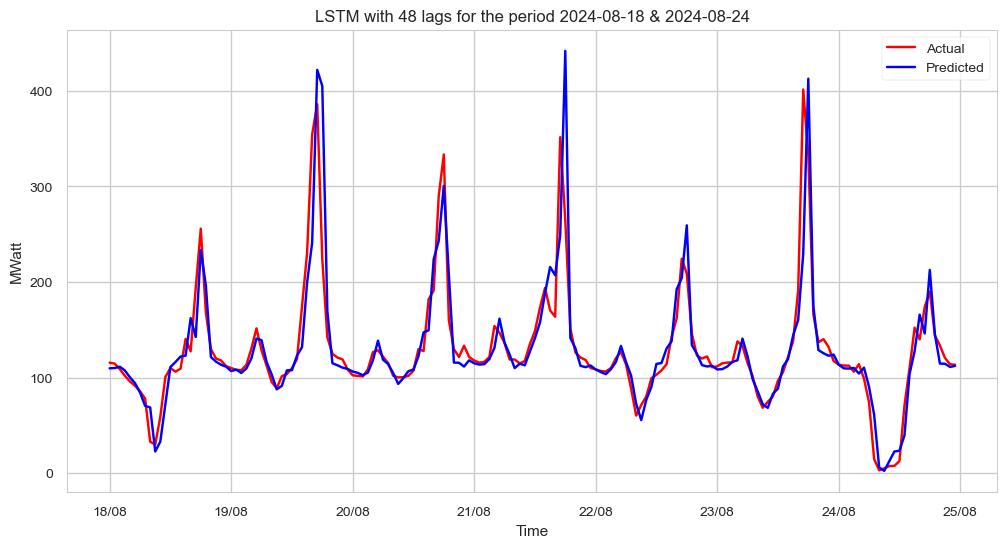

MAPE: 0.147000   --  MAE: 15.763000  --  MSE: 995.282000


In [21]:
dates = pd.date_range(start="2024-08-18 00:00:00", end="2024-08-24 23:00:00", freq='h')

plt.figure(figsize=(12,6))
weekly_evaluation(y_test[-14*24:-7*24], prediction_reverselyscaled_lstm_48[-14*24:-7*24], X_test,f'LSTM with 48 lags for the period {dates[0].date()} & {dates[-1].date()}',dates)

<Figure size 1500x600 with 0 Axes>

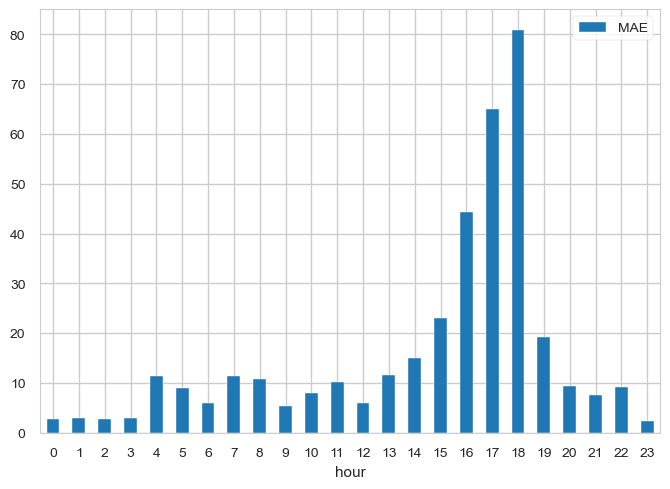

In [23]:
dates = pd.date_range(start='2024-08-18 00:00:00', end='2024-08-24 23:00:00', freq='h')

mae_lstm = (abs(y_test[-14*24:-7*24] - prediction_reverselyscaled_lstm_48[-14*24:-7*24]))

mae_df_lstm = pd.DataFrame(mae_lstm,index=dates,columns=['MAE'])
mae_df_lstm['hour'] = mae_df_lstm.index.hour

plt.figure(figsize=(15,6))
mae_df_lstm.groupby('hour').mean().plot(kind='bar',rot=0)

plt.show()

## Predicting into the Future

In [24]:
df_48 = cyclical_greece.loc['2024-08-29 00:00:00' : '2024-08-30 23:00:00']

df_last_day = cyclical_greece.loc['2024-08-31 00:00:00' : '2024-08-31 23:00:00']

dates = pd.date_range(start="2024-08-31 00:00:00", end="2024-08-31 23:00:00", freq='h')

In [25]:
df_48.shape 

(48, 8)

In [26]:
lag = 48
num_features = df_48.shape[1]
next_predictions = 24

In [27]:
data_scaled = scaler.transform(df_48.values)

In [28]:
last_sequence = data_scaled.reshape((1, lag, num_features))  # (1, 48, 12)  1 48αδα με 8 features

In [29]:
predictions = {
    'pred': [],
    'price1': [],
    'price2': [],
    'price3': [],
    'actual': []
}

# Predict 24 hours ahead (next_predictions)
for i in range(next_predictions):
    # Predict the next hour
    next_prediction = model_lstm_48.predict(last_sequence)
    
    # Inverse scale the prediction for the first feature
    prediction_reverselyscaled = scaler.inverse_transform(np.repeat(next_prediction, num_features, axis=-1))[:, 0]
    
    # Get the next timestamp
    next_timestamp = df_48.index[-1] + pd.Timedelta(hours=i + 1)
    #print('next_timestamp: ',next_timestamp)
    
    # Extract the next feature values from df_last_day for the next timestamp
    if next_timestamp in df_last_day.index:
        next_features = df_last_day.loc[next_timestamp, ['Provider 1', 'Provider 2', 'Provider 3', 'hour_sin',
       'hour_cos', 'dayofweek_sin', 'dayofweek_cos']].values
    else:
        next_features = np.zeros(num_features - 1)  # Default to zeros if timestamp is out of range
        print('Timestamp not in Next Day !!!')
    
    # Combine the predicted value with the next feature values
    new_row = np.concatenate(([prediction_reverselyscaled[0]], next_features))
    # Scale the new row
    new_row_scaled = scaler.transform(new_row.reshape(1, -1)).flatten()

    # Update the last_sequence with the new prediction and feature values
    next_input = np.append(last_sequence[0, 1:, :], [new_row_scaled], axis=0)  # Shift and append the prediction
    last_sequence = next_input.reshape((1, lag, num_features))
    
    # Update the predictions dictionary
    predictions['pred'].append(prediction_reverselyscaled[0])
    if next_timestamp in df_last_day.index:
        predictions['actual'].append(df_last_day.loc[next_timestamp, 'True value'])
        predictions['price1'].append(df_last_day.loc[next_timestamp, 'Provider 1'])
        predictions['price2'].append(df_last_day.loc[next_timestamp, 'Provider 2'])
        predictions['price3'].append(df_last_day.loc[next_timestamp, 'Provider 3'])
    else:
        predictions['price1'].append(None) # Append None if the timestamp is out of range
        predictions['price2'].append(None)
        predictions['price3'].append(None)
        

1/1 [==============================] - 0s 23ms/step


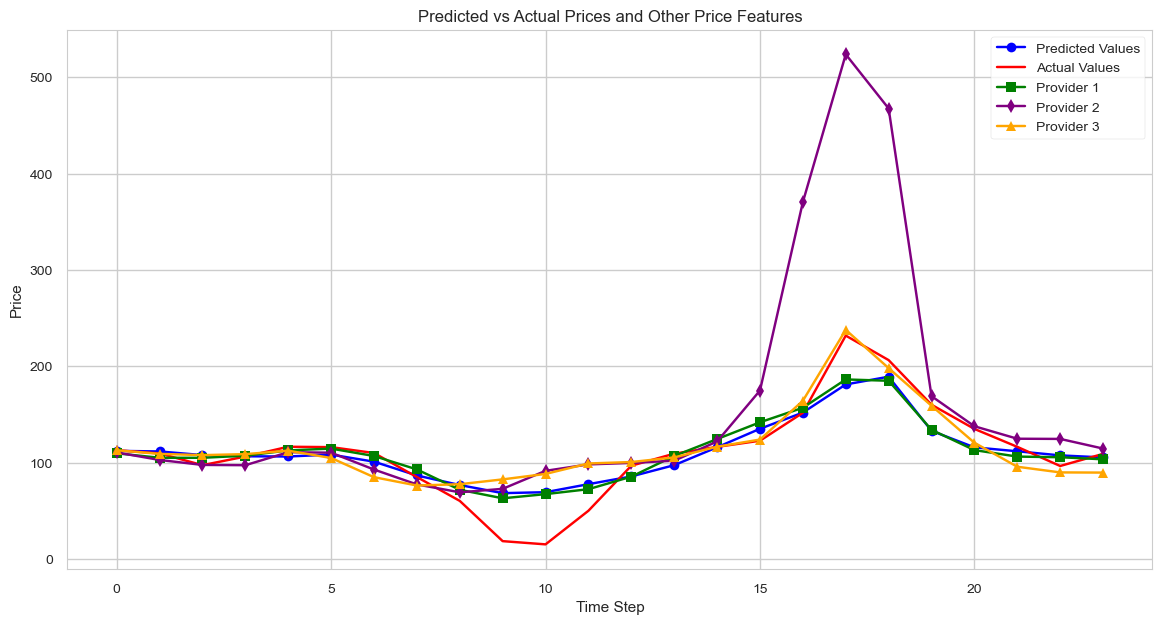

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(predictions['pred'], label='Predicted Values', color='blue', marker='o')
plt.plot(predictions['actual'], label='Actual Values', color='red', marker='x')
plt.plot(predictions['price1'], label='Provider 1', color='green', marker='s')
plt.plot(predictions['price2'], label='Provider 2', color='purple', marker='d')
plt.plot(predictions['price3'], label='Provider 3', color='orange', marker='^')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices and Other Price Features')
plt.legend()
plt.show()

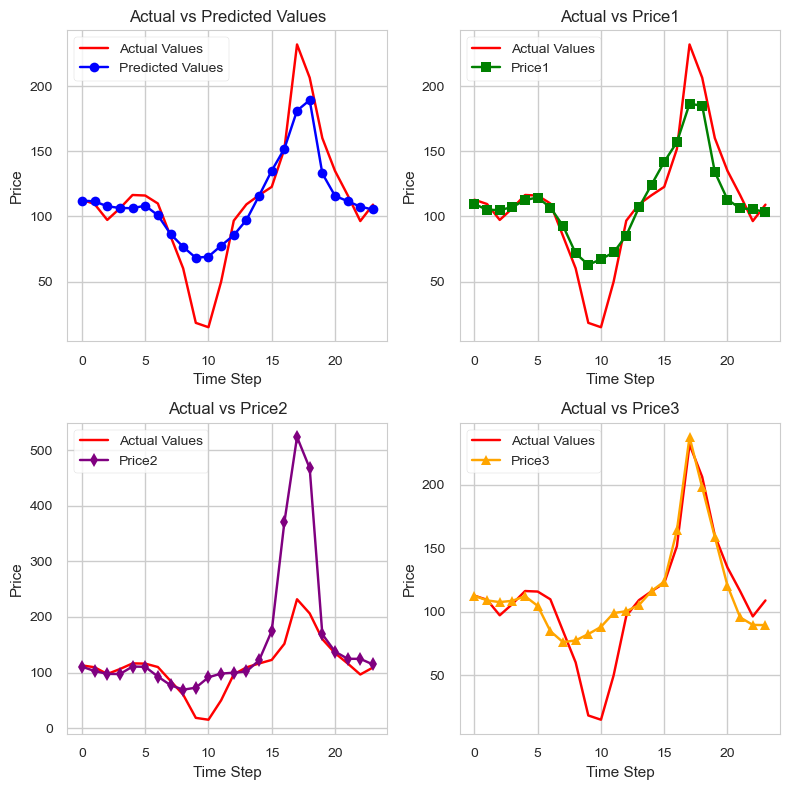

In [31]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot actual vs predicted values
axs[0, 0].plot(predictions['actual'], label='Actual Values', color='red', marker='x')
axs[0, 0].plot(predictions['pred'], label='Predicted Values', color='blue', marker='o')
axs[0, 0].set_xlabel('Time Step')
axs[0, 0].set_ylabel('Price')
axs[0, 0].set_title('Actual vs Predicted Values')
axs[0, 0].legend()

# Plot actual vs price1
axs[0, 1].plot(predictions['actual'], label='Actual Values', color='red', marker='x')
axs[0, 1].plot(predictions['price1'], label='Price1', color='green', marker='s')
axs[0, 1].set_xlabel('Time Step')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Actual vs Price1')
axs[0, 1].legend()

# Plot actual vs price2
axs[1, 0].plot(predictions['actual'], label='Actual Values', color='red', marker='x')
axs[1, 0].plot(predictions['price2'], label='Price2', color='purple', marker='d')
axs[1, 0].set_xlabel('Time Step')
axs[1, 0].set_ylabel('Price')
axs[1, 0].set_title('Actual vs Price2')
axs[1, 0].legend()

# Plot actual vs price3
axs[1, 1].plot(predictions['actual'], label='Actual Values', color='red', marker='x')
axs[1, 1].plot(predictions['price3'], label='Price3', color='orange', marker='^')
axs[1, 1].set_xlabel('Time Step')
axs[1, 1].set_ylabel('Price')
axs[1, 1].set_title('Actual vs Price3')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

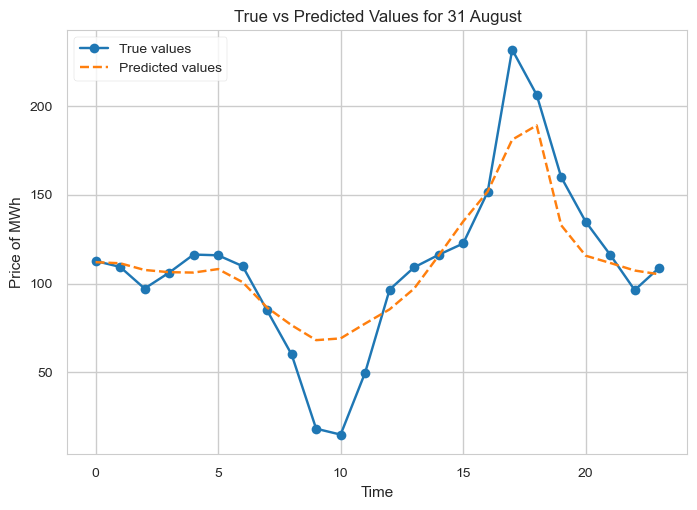

MAPE: 0.362000   --  MAE: 14.992000  --  MSE: 473.602000


In [32]:
daily_evaluation(predictions['actual'], predictions['pred'], df_last_day,'True vs Predicted Values for 31 August')

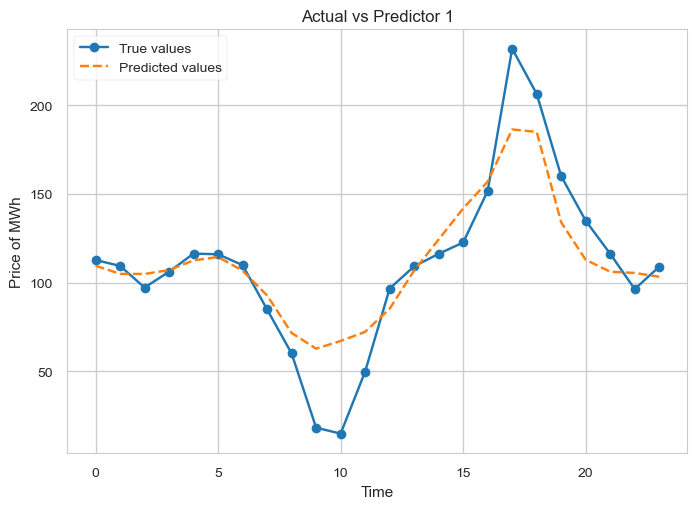

MAPE: 0.339000   --  MAE: 14.558000  --  MSE: 417.682000


In [33]:
daily_evaluation(predictions['actual'], predictions['price1'], df_last_day,'Actual vs Predictor 1')

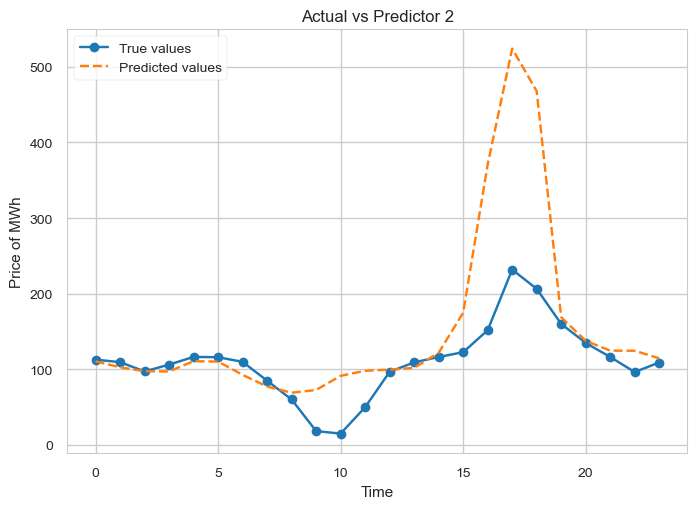

MAPE: 0.613000   --  MAE: 47.357000  --  MSE: 9046.506000


In [34]:
daily_evaluation(predictions['actual'], predictions['price2'], df_last_day,'Actual vs Predictor 2')

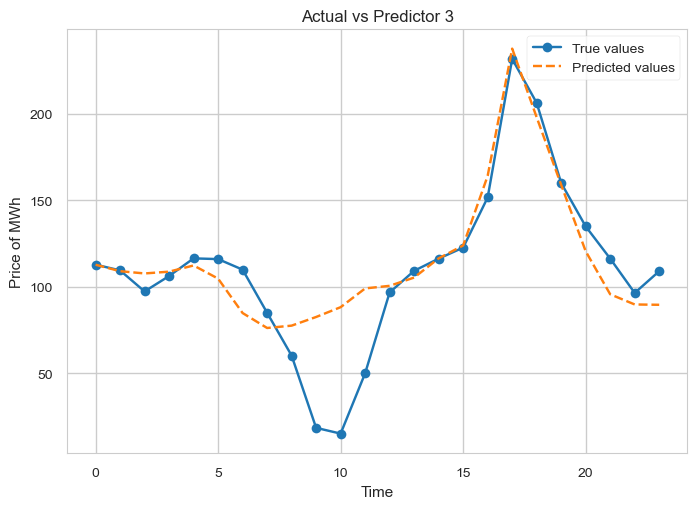

MAPE: 0.459000   --  MAE: 15.194000  --  MSE: 604.170000


In [35]:
daily_evaluation(predictions['actual'], predictions['price3'], df_last_day,'Actual vs Predictor 3')

In [36]:
dates = pd.date_range(start='2024-08-18 00:00:00', end='2024-08-24 23:00:00', freq='h')

mae_lstm = abs(a - b)

mae_df_lstm = pd.DataFrame(mae_lstm,index=dates,columns=['MAE'])
mae_df_lstm['hour'] = mae_df_lstm.index.hour

plt.figure(figsize=(15,6))
mae_df_lstm.groupby('hour').mean().plot(kind='bar',rot=0)

plt.show()

NameError: name 'a' is not defined